# Practical Work in AI: Enhancing item relevance scores with psychology-based interest over time for music recommender systems

Author: Laura Legat

Matriculation ID: 51868012

In [2]:
# import access to Google Drive files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import needed libraries

import os
import torch
import sys
import pandas as pd
import importlib

!pip install optuna
import optuna
import pickle
import matplotlib.pyplot as plt
import json
import numpy as np
from ast import literal_eval

!pip install tensorboardX

print('\nAll imports successful!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.9 MB/s eta 0:00:00

All imports successful!


In [ ]:
# Check if gpu is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_name = torch.cuda.get_device_name(device)
    print(f'Using GPU: {device_name}')
else:
    device = torch.device('cpu')
    print('Using CPU')

print(f'Current device: {device}')

Using CPU
Current device: cpu


In [ ]:
# create train-val-test sets for Ex2Vec training, as well as sequences for GRU4Rec training
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/preprocess.py -sl 50 -st 1 -sm Y

In [ ]:
# import custom code

# Append the directory containing 'data_sampler' and 'ex2vec' to Python's search path
sys.path.append('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI')

# imports modules for preparing data and for training/evaluating the ex2vec model
import data_sampler
from data_sampler import evaluate_data, get_rel_int_dict, update_rel_int_dict
from ex2vec import Ex2VecEngine
import ex2vec

#import dir of gru4rec_pytorch module to python path in order to be able to access GRU4Rec model class to be able to load it
sys.path.append('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork')
import gru4rec_pytorch
from evaluation import batch_eval

The size of the training set is: 161913
The size of the validation set is: 22940
The size of the test set is: 46757
The size of the combined (train+val) set is: 184853


In [ ]:
# USEFUL HELPER FNCTS

# convert best parameters to parameter string
def convert_to_param_str(best_param_path):
  with open(best_param_path, 'r') as f:
    data = json.load(f)

  params = data['best_params'] # extract only the parameter part
  param_str = ','.join([f'{key}={value}' for key,value in params.items()])

  return param_str

In [ ]:
# train standard ex2vec baseline (no GRU4rec item embeddings, no hyperparameter tuning)
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -n ex2vec_baseline

The size of the training set is: 161913
The size of the validation set is: 22940
The size of the test set is: 46757
The size of the combined (train+val) set is: 184853
Ex2Vec model is created with the following parameters for this run:

alias:ex2vec_baseline__BS512LR5e-05L_DIM64N_EP100
num_epoch:100
batch_size:512
optimizer:adam
lr:5e-05
rmsprop_alpha:0.99
momentum:0
n_users:465
n_items:879
latent_dim:64
num_negative:0
l2_regularization:0.001
use_cuda:False
device_id:0
pretrain:False
pretrain_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/Ex2Vec_pretrained.pt
model_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/{}_Epoch{}_f1{:.4f}.pt
chckpt_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/chckpts/{}_Epoch{}_f1{:.4f}.pt
Ex2Vec(
  (user_lamb): Embedding(465, 1)
  (user_bias): Embedding(465, 1)
  (item_bias): Embedding(879, 1)
  (embedding_user): Embedding(465, 64)
  (embedding_item): Embedding(879, 64)
  (logistic): Sigmoid()

In [ ]:
#!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optuna_paropt.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/processed.csv -opf /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/paramspaces/deezer_parspace_Ex2Vec.json -nt 2 -p /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -o /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec_DEL.json -mo ex2vec -ovc /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/tables/optuna_vis_ex2vec_DEL.csv -ovp /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec_DEL.pkl -sp "sqlite:////content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec_DEL.db" -sn "ex2vec_study1_DEL"
#!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optuna_paropt.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_train_SM.csv -opf /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/paramspaces/deezer_parspace_GRU4Rec.json -nt 1 -p /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/run.py -o /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_gru4rec_DEL.json -mo gru4rec -t /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_val_SM.csv -m "1 5 10 20" -ik "itemId" -tk "timestamp" -ovc /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/tables/optuna_vis_gru4rec_DEL.csv -ovp /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_gru4rec_DEL.pkl -sp "sqlite:////content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_gru4rec_DEL.db" -sn "gru4rec_study1_DEL"

In [ ]:
# hyperparameter tuning standard ex2vec
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optuna_paropt.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/processed.csv -opf /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/paramspaces/deezer_parspace_Ex2Vec.json -nt 1 -p /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -o /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec.json -mo ex2vec -ovc /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/tables/optuna_vis_ex2vec.csv -ovp /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec.pkl -sp "sqlite:////content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec.db" -sn "ex2vec_study1"

--------------------------------------------------------------------------------
PARAMETER SPACE:
	PARAMETER name=num_epoch 	 type=categorical 	 options: [30,50,100]
	PARAMETER name=batch_size 	 type=categorical 	 options: [256,512,1024,2048]
	PARAMETER name=learning_rate 	 type=float 	 range=[1e-05..0.001] (step=N/A) 	 LOG scale
	PARAMETER name=rmsprop_alpha 	 type=float 	 range=[0.3..1.0] (step=0.1) 	 UNIFORM scale
	PARAMETER name=momentum 	 type=float 	 range=[0.0..0.9] (step=0.05) 	 UNIFORM scale
	PARAMETER name=l2_regularization 	 type=float 	 range=[1e-05..0.01] (step=N/A) 	 LOG scale
--------------------------------------------------------------------------------
[I 2024-08-30 16:27:38,125] Using an existing study with name 'ex2vec_study1' instead of creating a new one.
The size of the training set is: 161913
The size of the validation set is: 22940
The size of the test set is: 46757
The size of the combined (train+val) set is: 184853
Ex2Vec model is created with the following p

In [ ]:
# re-train ex2vec with best parameters (no GRU4Rec item embeddings)
ex2vec_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec.json')
print(ex2vec_best_param_str)

command = f'python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -ps {ex2vec_best_param_str} -t N -n ex2vec_baseline_finaltrain -ut Y'
get_ipython().system(command)

num_epoch=100,batch_size=256,optimizer=adam,learning_rate=5e-05,rmsprop_alpha=1.0,momentum=0.9,l2_regularization=0.007774279695216305
The size of the training set is: 170321
The size of the validation set is: 24154
The size of the test set is: 49160
The size of the combined (train+val) set is: 194475
Ex2Vec model is created with the following parameters for this run:

alias:ex2vec_baseline_finaltrain__BS256LR5e-05L_DIM64N_EP100
num_epoch:100
batch_size:256
optimizer:adam
lr:5e-05
rmsprop_alpha:1.0
momentum:0.9
n_users:463
n_items:879
latent_dim:64
num_negative:0
l2_regularization:0.007774279695216305
use_cuda:True
device_id:0
pretrain:False
pretrain_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/Ex2Vec_pretrained.pt
model_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/{}_Epoch{}_f1{:.4f}.pt
chckpt_dir:/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/chckpts/{}_Epoch{}_f1{:.4f}.pt
Ex2Vec(
  (user_lamb): Embedding(463, 1)
  (user

In [ ]:
# initial training + hyperparameter optimization with seq_train.csv and seq_val.csv on GRU4Rec
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optuna_paropt.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_train.csv -opf /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/paramspaces/deezer_parspace_GRU4Rec.json -nt 1 -p /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/run.py -o /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_gru4rec.json -mo gru4rec -t /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_val.csv -m "1 5 10 20" -ik "itemId" -tk "timestamp" -ovc /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/tables/optuna_vis_gru4rec.csv -ovp /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_gru4rec.pkl -sp "sqlite:////content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_gru4rec.db" -sn "gru4rec_study1"

--------------------------------------------------------------------------------
PARAMETER SPACE:
	PARAMETER name=loss 	 type=categorical 	 options: [bpr-max,cross-entropy]
	PARAMETER name=constrained_embedding 	 type=categorical 	 options: [False,True]
	PARAMETER name=embedding 	 type=categorical 	 options: [0,64]
	PARAMETER name=elu_param 	 type=categorical 	 options: [0.5,1,0]
	PARAMETER name=layers 	 type=int 	 range=[64..64] (step=1) 	 UNIFORM scale
	PARAMETER name=n_epochs 	 type=categorical 	 options: [5,10,15]
	PARAMETER name=batch_size 	 type=int 	 range=[128..512] (step=16) 	 UNIFORM scale
	PARAMETER name=dropout_p_embed 	 type=float 	 range=[0.0..0.5] (step=0.05) 	 UNIFORM scale
	PARAMETER name=dropout_p_hidden 	 type=float 	 range=[0.0..0.7] (step=0.05) 	 UNIFORM scale
	PARAMETER name=learning_rate 	 type=float 	 range=[0.0001..0.05] (step=0.001) 	 UNIFORM scale
	PARAMETER name=momentum 	 type=float 	 range=[0.0..0.9] (step=0.05) 	 UNIFORM scale
	PARAMETER name=n_sample 	 t

In [ ]:
# combine seq_train and seq_val to seq_combined.csv for final training/eval

train_csv = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_train.csv')
val_csv = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_val.csv')

# remove header row from the second df
val_csv = val_csv.iloc[0:].reset_index(drop=True)

# stack rows of both csv's
combined_csv = pd.concat([train_csv, val_csv], ignore_index=True)

# Save the combined DataFrame
combined_csv.to_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_combined.csv', index=False)

In [ ]:
# retrain gru4rec with best params
"""
params: (from https://github.com/hidasib/GRU4Rec/blob/master/README.md)
  -t    Testset path
  -pf   Parameter file path
  -s    Path to save the state dict to
  -m    Calculate recall, MRR etc. at the given list length
  -ik   Item key
  -tk   Timestamp key
  -d    Device
"""

gru4rec_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_gru4rec.json')

command = f'python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/run.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_combined.csv -ps {gru4rec_best_param_str} -t /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_test.csv -s /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams.pt -m 1 5 10 20 -ik "itemId" -tk "timestamp" -pm recall -lpm'
get_ipython().system(command)

[1, 5, 10, 20]
Creating GRU4Rec model on device "cpu"
SET   loss                    TO   cross-entropy         (type: <class 'str'>)
SET   constrained_embedding   TO   False                 (type: <class 'bool'>)
SET   embedding               TO   0                     (type: <class 'int'>)
SET   elu_param               TO   0.0                   (type: <class 'float'>)
SET   layers                  TO   [64]                  (type: <class 'list'>)
SET   n_epochs                TO   10                    (type: <class 'int'>)
SET   batch_size              TO   224                   (type: <class 'int'>)
SET   dropout_p_embed         TO   0.1                   (type: <class 'float'>)
SET   dropout_p_hidden        TO   0.0                   (type: <class 'float'>)
SET   learning_rate           TO   0.0181                (type: <class 'float'>)
SET   momentum                TO   0.30000000000000004   (type: <class 'float'>)
SET   n_sample                TO   2048                  (type: <

In [ ]:
# optional: move model to GPU for inference
cpu_model = '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams.pt'

gru4rec_model = torch.load(cpu_model)

gru4rec_model.to('cuda')
torch.save(gru4rec_model, '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams_cuda.pt')

In [ ]:
# visualize optuna results for ex2vec
# Load study from pickle file
with open('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec.pkl', 'rb') as f:
    study = pickle.load(f)

# Load trials data from CSV
trials_df = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_vis_ex2vec.csv')

# Optuna visualizations
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.show()

optuna.visualization.matplotlib.plot_slice(study)
plt.show()

optuna.visualization.matplotlib.plot_edf(study)
plt.show()

# Display the trials DataFrame
display(trials_df)


In [ ]:
# visualize optuna results for ex2vec
# Load study from pickle file
with open('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec_gruembds.pkl', 'rb') as f:
    study = pickle.load(f)

# Load trials data from CSV
trials_df = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/tables/optuna_vis_ex2vec_gruembds.csv')

# Optuna visualizations
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.show()

optuna.visualization.matplotlib.plot_slice(study)
plt.show()

optuna.visualization.matplotlib.plot_edf(study)
plt.show()

# Display the trials DataFrame
display(trials_df)

<ipython-input-51-3be1713effff>:10: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


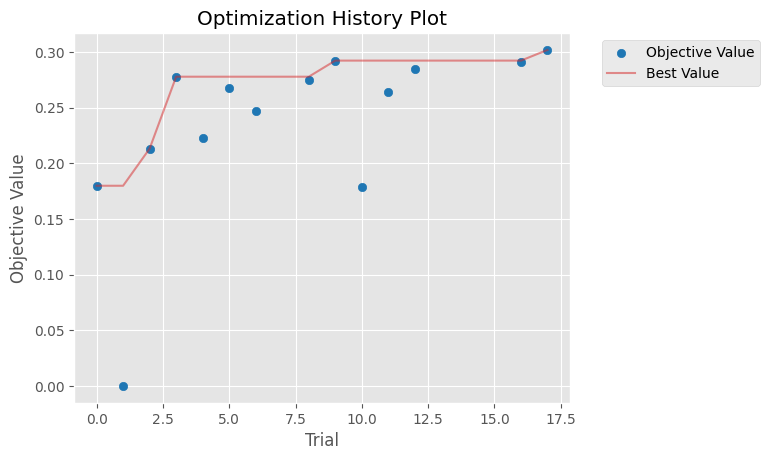

<ipython-input-51-3be1713effff>:13: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


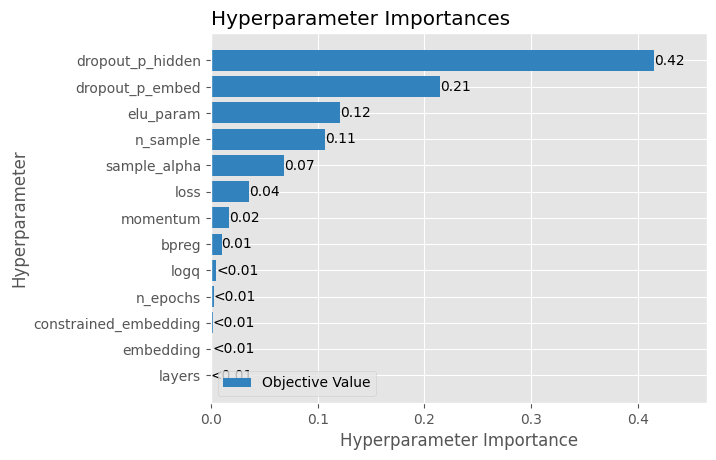

<ipython-input-51-3be1713effff>:16: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)
/usr/local/lib/python3.10/dist-packages/optuna/visualization/matplotlib/_parallel_coordinate.py:135: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax2.set_ylim(dim.range[0], dim.range[1])


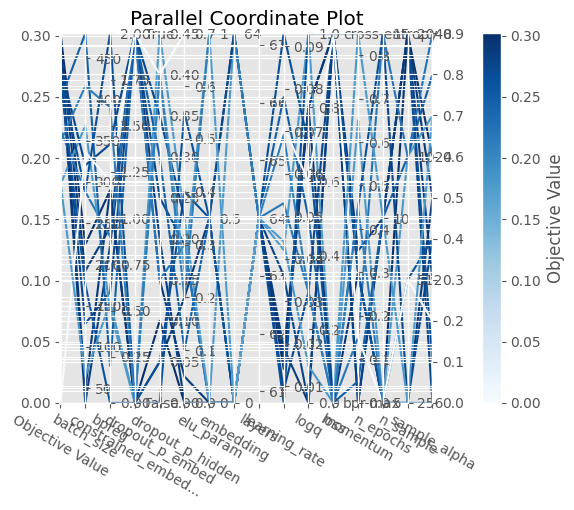

<ipython-input-51-3be1713effff>:19: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)
/usr/local/lib/python3.10/dist-packages/optuna/visualization/matplotlib/_slice.py:162: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(xlim[0], xlim[1])


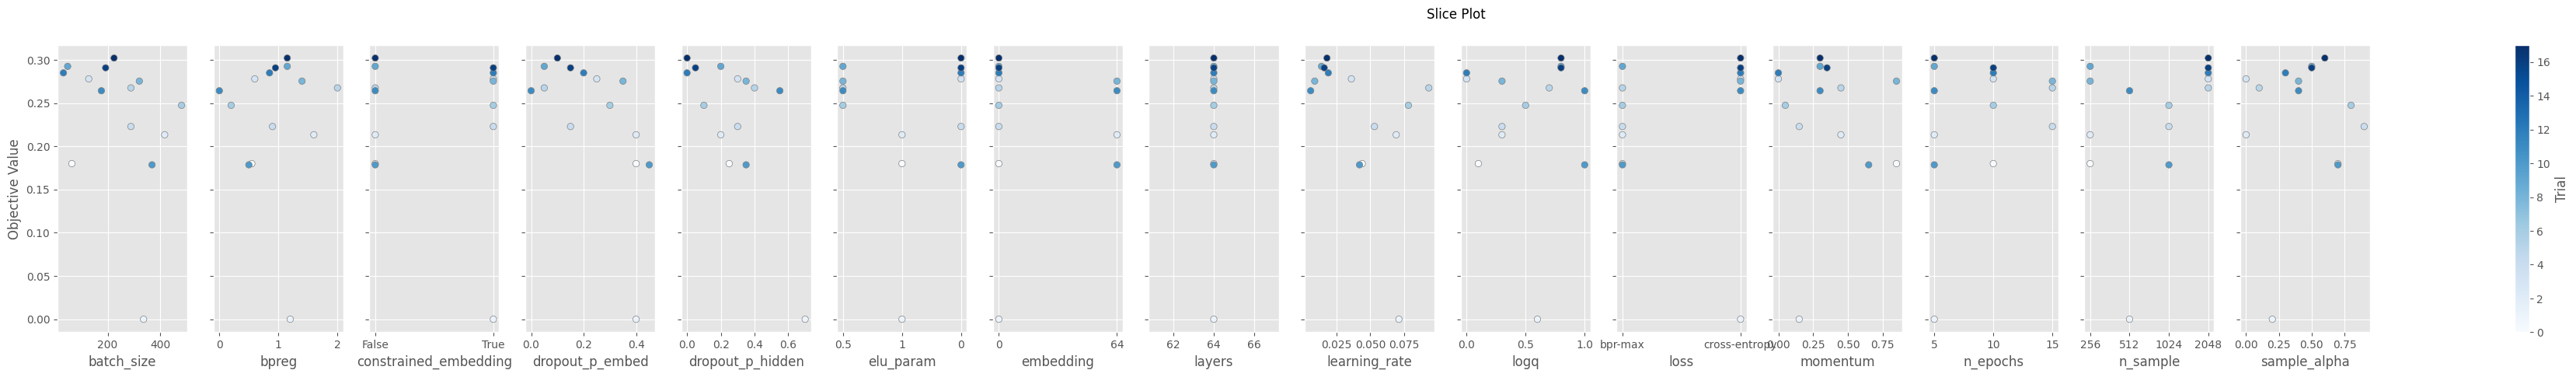

<ipython-input-51-3be1713effff>:22: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf(study)


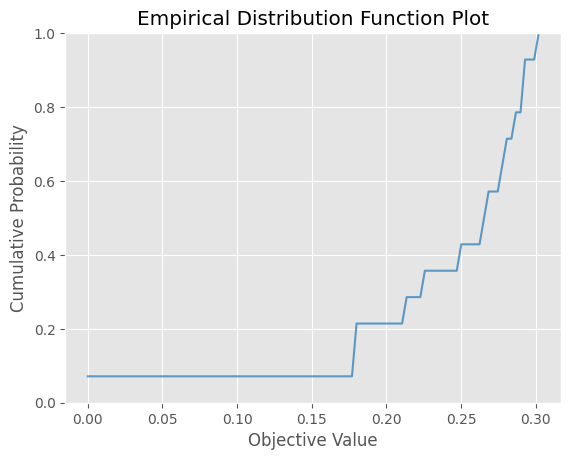

,Unnamed: 0,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_bpreg,params_constrained_embedding,params_dropout_p_embed,...,params_embedding,params_layers,params_learning_rate,params_logq,params_loss,params_momentum,params_n_epochs,params_n_sample,params_sample_alpha,state
0,0,0,0.179916,2024-08-07 12:49:43.742358,2024-08-07 14:06:24.536519,0 days 01:16:40.794161,64,0.55,False,0.40,...,0,64,0.0441,0.1,bpr-max,0.85,10,256,0.7,COMPLETE
1,1,1,0.000000,2024-08-08 11:32:20.670587,2024-08-08 11:38:03.223562,0 days 00:05:42.552975,336,1.20,True,0.40,...,0,64,0.0711,0.6,cross-entropy,0.15,5,512,0.2,COMPLETE
2,2,2,0.213290,2024-08-08 12:03:28.841255,2024-08-08 12:09:10.421644,0 days 00:05:41.580389,416,1.60,False,0.40,...,64,64,0.0691,0.3,bpr-max,0.45,5,256,0.0,COMPLETE
3,3,3,0.277929,2024-08-08 12:12:17.560668,2024-08-08 12:39:06.414886,0 days 00:26:48.854218,128,0.60,True,0.25,...,0,64,0.0361,0.0,cross-entropy,0.00,10,2048,0.0,COMPLETE
4,4,4,0.222815,2024-08-08 12:39:06.456161,2024-08-08 13:01:13.221934,0 days 00:22:06.765773,288,0.90,True,0.15,...,0,64,0.0531,0.3,bpr-max,0.15,15,1024,0.9,COMPLETE
5,5,5,0.267481,2024-08-08 13:01:13.261866,2024-08-08 13:26:41.093066,0 days 00:25:27.831200,288,2.00,False,0.05,...,0,64,0.0931,0.7,bpr-max,0.45,15,2048,0.1,COMPLETE
6,6,6,0.247359,2024-08-08 13:26:41.131606,2024-08-08 13:35:50.587864,0 days 00:09:09.456258,480,0.20,True,0.30,...,0,64,0.0781,0.5,bpr-max,0.05,10,1024,0.8,COMPLETE
7,7,7,NaN,2024-08-08 13:35:50.627186,2024-08-08 13:36:16.156289,0 days 00:00:25.529103,272,1.60,True,0.00,...,64,64,0.0671,0.4,bpr-max,0.55,5,2048,0.1,FAIL
8,8,8,0.275317,2024-08-08 13:40:42.239116,2024-08-08 13:58:15.046194,0 days 00:17:32.807078,320,1.40,True,0.35,...,64,64,0.0091,0.3,cross-entropy,0.85,15,256,0.4,COMPLETE
9,9,9,0.292402,2024-08-08 13:58:15.091564,2024-08-08 14:49:04.832085,0 days 00:50:49.740521,48,1.15,False,0.05,...,0,64,0.0141,0.8,bpr-max,0.30,5,256,0.5,COMPLETE


In [ ]:
# visualize optuna results for ex2vec
# Load study from pickle file
with open('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_gru4rec.pkl', 'rb') as f:
    study = pickle.load(f)

# Load trials data from CSV
trials_df = pd.read_csv('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/tables/optuna_vis_gru4rec.csv')

# Optuna visualizations
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.show()

optuna.visualization.matplotlib.plot_slice(study)
plt.show()

optuna.visualization.matplotlib.plot_edf(study)
plt.show()

# Display the trials DataFrame
display(trials_df)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/runs

# Combining GRU4Rec & Ex2Vec Idea 1: Using GRU4Rec's pre-trained item embeddings in Ex2Vec training

We want to extract the pre-trained item embeddings after training the GRU4Rec model and insert them into Ex2Vec instead of its initial ones. This is done with the idea of bringing in dynamic, intra-session item information as part of Ex2Vec training.

In [ ]:
# hyperparameter optimization of Ex2Vec with item embeddings extracted from pre-trained GRU4Rec
!python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optuna_paropt.py /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/processed.csv -opf /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/GRU4Rec_Fork/paramspaces/deezer_parspace_Ex2Vec.json -nt 10 -p /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -o /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec_gruembds.json -mo ex2vec -ovc /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_vis_ex2vec_gruembds.csv -ovp /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec_gruembds.pkl -sp "sqlite:////content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/optuna_study_ex2vec_gruembds.db" -sn "teststudy_ex2vec_gruembds" -ep /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams_cuda.pt

In [ ]:
# re-train Ex2Vec (with GRU embeddings) with best parameters found through hyperparameter optim
ex2vec_gruembds_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec_gruembds.json') #get parameter string of best parameters
print(ex2vec_gruembds_best_param_str)

command = f'python /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/train.py -ps {ex2vec_gruembds_best_param_str} -t N -ep /content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams.pt' #re-run training with best parameters
get_ipython().system(command)

# Combining GRU4Rec & Ex2Vec Idea 2: Combining GRU4Rec's relevance scores with Ex2vec Interest scores and re-rank top-k next items

## Loading and Preparing Ex2Vec for Inference

In [ ]:
from collections import OrderedDict

# load ex2vec best parameters and use them as config
ex2vec_best_param_str = convert_to_param_str('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/optim/best_params_ex2vec.json')
ex2vec_config = OrderedDict([x.split('=') for x in ex2vec_best_param_str.split(',') if "=" in x])

# set pretrain to true
config = config = {
    "alias": 'ex2vec_baseline_finaltrain',
    "num_epoch": int(ex2vec_config['num_epoch']),
    "batch_size": int(ex2vec_config['batch_size']),
    "optimizer": 'adam',
    "lr": float(ex2vec_config['learning_rate']),
    "rmsprop_alpha": float(ex2vec_config['rmsprop_alpha']),
    "momentum": float(ex2vec_config['momentum']),
    "n_users": 463,
    "n_items": 879,
    "latent_dim": 64,
    "num_negative": 0,
    "l2_regularization": float(ex2vec_config['l2_regularization']),
    "use_cuda": True,
    "device_id": 0,
    "pretrain": True,
    "pretrain_dir": "/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/ex2vec_baseline__BS512LR5e-05L_DIM64N_EP50_Epoch49_f10.5778.pt",
    "model_dir": "/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/{}_Epoch{}_f1{:.4f}.pt",
    "chckpt_dir":"/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/chckpts/{}_Epoch{}_f1{:.4f}.pt",
}

# instantiate ex2vec model
ex2vec_pre = Ex2VecEngine(config)

Ex2Vec(
  (user_lamb): Embedding(463, 1)
  (user_bias): Embedding(463, 1)
  (item_bias): Embedding(879, 1)
  (embedding_user): Embedding(463, 64)
  (embedding_item): Embedding(879, 64)
  (logistic): Sigmoid()
)
global_lamb <class 'torch.Tensor'> torch.Size([])
alpha <class 'torch.Tensor'> torch.Size([])
beta <class 'torch.Tensor'> torch.Size([])
gamma <class 'torch.Tensor'> torch.Size([])
cutoff <class 'torch.Tensor'> torch.Size([])
user_lamb.weight <class 'torch.Tensor'> torch.Size([463, 1])
user_bias.weight <class 'torch.Tensor'> torch.Size([463, 1])
item_bias.weight <class 'torch.Tensor'> torch.Size([879, 1])
embedding_user.weight <class 'torch.Tensor'> torch.Size([463, 64])
embedding_item.weight <class 'torch.Tensor'> torch.Size([879, 64])


In [ ]:
ex2vec_pre.model.eval() # put model into evaluation mode for inference

Ex2Vec(
  (user_lamb): Embedding(463, 1)
  (user_bias): Embedding(463, 1)
  (item_bias): Embedding(879, 1)
  (embedding_user): Embedding(463, 64)
  (embedding_item): Embedding(879, 64)
  (logistic): Sigmoid()
)

## Inference with GRU4Rec

In [ ]:
# load current best GRU4Rec model and put it into eval mode for inference
gru = torch.load('/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/models/GRU4Rec_bestparams_cuda.pt')
gru.model.eval()

GRU4RecModel(
  (GE): GRUEmbedding(
    (Wx0): Embedding(879, 192, sparse=True)
  )
  (DE): Dropout(p=0.1, inplace=False)
  (G): ModuleList()
  (D): ModuleList()
  (Wy): Embedding(879, 64, sparse=True)
  (By): Embedding(879, 1, sparse=True)
)

In [ ]:
# define the data used for inference
test_data_path = '/content/drive/MyDrive/JKU/practical_work/Practical-Work-AI/data/seq_test.csv'
test_data = pd.read_csv(test_data_path, sep=',', converters={"relational_interval": literal_eval})

In [ ]:
# get histories of 10 unique users
random_users = np.random.choice(test_data['userId'], size=10)
test_data_sm = test_data[test_data['userId'].isin(random_users)]
# filter out only users with >= 10 sessions
test_data_sm = test_data_sm.groupby('userId').filter(lambda x: x['SessionId'].nunique() >= 10)

def split_off_sessions(user_df, n):
  """
  Helper function for slicing out the first n sessions from a user history.
  """
  unique_sessions = user_df['SessionId'].unique()
  first_n_sessions = unique_sessions[:n]
  return user_df[user_df['SessionId'].isin(first_n_sessions)]

n = 10
test_data_sm = test_data_sm.groupby('userId').apply(lambda x: split_off_sessions(x,n)).reset_index(drop=True)
test_data_sm

,userId,itemId,timestamp,SessionId,relational_interval
0,37,82,5239063,37_515,"[1360.9202777777778, 1342.796388888889, 1340.3..."
1,37,62,5239421,37_515,"[1342.7586111111111, 1340.3794444444445, 1323...."
2,37,651,5374171,37_515,"[859.2991666666667, 852.3286111111111, 835.328..."
3,37,638,5487485,37_515,"[866.3241666666667, 847.9713888888889, 835.387..."
4,37,295,5835781,37_515,"[1326.03, 741.6425, 735.0672222222222]"
...,...,...,...,...,...
4995,429,807,5497851,429_576,"[783.7930555555556, 783.7188888888888, 667.125..."
4996,429,815,5497979,429_576,"[784.1980555555556, 784.1608333333334, 708.776..."
4997,429,812,5498108,429_576,"[784.1255555555556, 716.1377777777777, 577.369..."
4998,429,808,5498111,429_576,"[652.9475, 635.7311111111111, 612.840277777777..."


In [ ]:
cutoff = [20]
eval_res = batch_eval(gru, test_data_sm, cutoff, batch_size=50, ex2vec=ex2vec_pre.model)

for c in cutoff:
  print('\nRecall@{}: {:.6f} MRR@{}: {:.6f}'.format(c, eval_res[0][c], c, eval_res[1][c]))

Using existing item ID map
The dataframe is not sorted by SessionId, sorting now
Data sorting took 0.00s

Recall@20: 0.301020 MRR@20: 0.082453


In [ ]:
cutoff = [20]
eval_res = batch_eval(gru, ex2vec_pre.model, test_data_sm, cutoff, batch_size=50, combination=True, k=50)

for c in cutoff:
  print('\nRecall@{}: {:.6f} MRR@{}: {:.6f}'.format(c, eval_res[0][c], c, eval_res[1][c]))

Using existing item ID map
The dataframe is already sorted by SessionId

Recall@20: 0.053673 MRR@20: 0.010933
